In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class OptionPricing:
    def __init__(self, S_0, K, sigma, r, T, option_type, option_style):
        self.S_0 = S_0
        self.K = K
        self.sigma = sigma
        self.r = r
        self.T = T
        self.option_type = option_type
        self.option_style = option_style
        
    def __cholesky_decomposition(self, rho):
        corr_matrix = np.array([1, rho, rho, 1]).reshape(2, -1)
        cho_matrix = np.linalg.cholesky(corr_matrix)
        return cho_matrix
        
    def heston_pricing(self, v_0, kappa, theta, rho, steps, iterations, uai=0):
        dt = self.T / steps
        cho_matrix = self.__cholesky_decomposition(rho)
        rand = np.random.standard_normal([2, iterations, steps+1])
        
        v = np.zeros([iterations, steps+1])
        v[:, 0] = v_0
        
        self.S = np.zeros([iterations, steps+1])
        self.S[:, 0] = self.S_0
        
        for t in range(1, steps+1):
            z = np.dot(cho_matrix, rand[:, :, t])

            v[:, t] = np.maximum(
                0, 
                v[:, t-1] 
                + kappa * (theta - v[:, t-1]) * dt 
                + np.sqrt(v[:, t-1]) * self.sigma * z[0] * np.sqrt(dt)
            )
            
            self.S[:, t] = (
                self.S[:, t-1] * np.exp((self.r - 0.5 * v[:, t]) * dt + 
                np.sqrt(v[:, t]) * z[1] * np.sqrt(dt))
            )
        
        barrier_uai = ~(self.S >= uai)
        
        if self.option_type == "call":    
            self.Op = np.maximum(self.S - self.K, 0)
            
        elif self.option_type == "put":
            self.Op = np.maximum(self.K - self.S, 0)
            
        for i in range(iterations):
            if barrier_uai[i].all():
                self.Op[i, :] = 0
            
        pricing = np.exp(-self.r * self.T) * self.Op[:, -1]
    
        if self.option_type == "put" and self.option_style == "American":
            pricing = []
            for i in range(iterations):              
                for j in range(steps+1):
                    if self.Op[i, j] >= self.Op[i, -1] * np.exp(-self.r * self.T):
                        pricing.append(self.Op[i, j] * np.exp(-self.r * j / steps))
                        break
    
        price = np.mean(pricing)
            
        return round(price, 2), self.S, v
    
    
    def merton_pricing(self, lamb, mu, delta, steps, iterations, dai=np.inf):
        rj = lamb * (np.exp(mu + 0.5 * delta**2) - 1)
        dt = self.T / steps
        z1 = np.random.standard_normal([iterations, steps+1])
        z2 = np.random.standard_normal([iterations, steps+1])
        y = np.random.poisson(lamb * dt, [iterations, steps+1])
        
        self.S = np.zeros([iterations, steps+1])
        self.S[:, 0] = self.S_0
        
        for t in range(1, steps+1):
            self.S[:, t] = (
                self.S[:, t-1] 
                * (
                    np.exp((r - rj - 0.5 * self.sigma**2) * dt + self.sigma * np.sqrt(dt) * z1[:, t])
                    + (np.exp(mu + delta * z2[:, t]) - 1) * y[:, t]
                )
            )
                
                
            self.S[:, t] = np.maximum(self.S[:, t], 0.0001)
            
        barrier_dai = ~(self.S <= dai)              
        
        if self.option_type == "call":    
            self.Op = np.maximum(self.S - self.K, 0)
            
        elif self.option_type == "put":
            self.Op = np.maximum(self.K - self.S, 0)
            
        for i in range(iterations):
            if barrier_dai[i].all():
                self.Op[i, :] = 0
               
        pricing = np.exp(-self.r * self.T) * self.Op[:, -1]
    
        if self.option_type == "put" and self.option_style == "American":
            pricing = []
            for i in range(iterations):              
                for j in range(steps+1):
                    if self.Op[i, j] >= self.Op[i, -1] * np.exp(-self.r * self.T):
                        pricing.append(self.Op[i, j] * np.exp(-self.r * j / steps))
                        break
    
        price = np.mean(pricing)
            
        return round(price, 2)

## General parameters

$
\hspace{1em}S_0 = 80 \\
\hspace{1em}r = 5.5\% \\
\hspace{1em}\sigma = 35\% \\
\hspace{1em}\text{Time to maturity} = 3 months \\
$

# Step 1

## Stochastic Volatility Modeler

For the Heston model, you can use the following parameters:

$
\hspace{1em}\nu_0 = 3.2\% \\
\hspace{1em}\kappa_\nu = 1.85 \\
\hspace{1em} \theta_\nu = 0.045
$


$
\begin{align*}
S_t &= S_{t-1}e^{\left(r - \frac{\nu_t}{2}\right)dt} + \sigma\sqrt{\nu_t}dZ_1 \\
\nu_t &= \nu_{t-1} + \kappa\left(\theta - \nu_{t-1}\right)dt + \sigma\sqrt{\nu_{t-1}}dZ_2 \\
\mathbb{E}\left[dZ_1^S, dZ_2^\nu\right] &= \rho dt
\end{align*}
$

$
\hspace{1em}\text{where,} \\
\hspace{2em}\nu = \text{Drift of the stock process} \\
\hspace{2em}\kappa = \text{Mean reversion coefficient of the variance process} \\
\hspace{2em}\theta = \text{Long term mean of the variance process} \\
\hspace{2em}\sigma = \text{volatility coefficient of the variance process} \\
\hspace{2em}\rho = \text{correlation between $W_1$ and $W_2$}
$

We implemented an engine which randomly evolves a stock price from time 0 to time T according to a geometric Brownian motion and use the engine to write Monte Carlo pricers for all the parameters  mentioned above. The engine generates a final stock value. The option's pay-off for that final value is then evaluated and discounted. These values are then averaged over a large number of paths.

<div style="page-break-after: always;"></div>

#### 5. Using the Heston Model and Monte-Carlo simulation, price an ATM European call and put, using a correlation value of -0.30.

In [35]:
S_0 = 80
K = 80
r = 0.055
sigma = 0.35
T = 20/250

v_0 = 0.032
kappa = 1.85
theta = 0.045
rho_q5 = -0.30
steps = 20

First, we will determine the optimal number of iterations by running the simulation on various iterations and letting the price to converge.

Pricing is computed using the Heston model by creating paths for the model to determine the value of the financial asset by placing the parameters in the model and using Monte Carlo to determine the value of the underlying asset. The model's accuracy converge at 20,000 paths over 365-time steps. The accuracy of the model increases as we increase the number of time tracks.

In [43]:
iterations = 100

np.random.seed(42)

call_option = OptionPricing(S_0, K, sigma, r, T, "call", "European")

call_price_heston_q5 = call_option.heston_pricing(v_0, kappa, theta, rho_q5, steps, iterations)

print(f"Price of European call option using Heston pricing model with -0.3 rho: {call_price_heston_q5}")

Price of European call option using Heston pricing model with -0.3 rho: (1.38, array([[80.        , 79.27976471, 78.34793458, ..., 76.58577221,
        76.75537932, 78.12559007],
       [80.        , 79.97726155, 80.1369578 , ..., 82.92114394,
        82.89710761, 82.91108898],
       [80.        , 80.30055659, 80.50055781, ..., 78.55399823,
        78.8006564 , 79.41637619],
       ...,
       [80.        , 80.7928243 , 81.2405743 , ..., 82.41406564,
        82.80310897, 82.36554614],
       [80.        , 80.03272407, 79.81022718, ..., 75.26555703,
        75.20272056, 77.08803389],
       [80.        , 80.25341826, 79.63918181, ..., 77.8298014 ,
        76.40631917, 76.61219509]]), array([[0.032     , 0.0315487 , 0.03419481, ..., 0.02210315, 0.01762472,
        0.02213444],
       [0.032     , 0.0323636 , 0.02678343, ..., 0.01197828, 0.0140117 ,
        0.01469004],
       [0.032     , 0.03090389, 0.0252547 , ..., 0.02655096, 0.02601782,
        0.02220808],
       ...,
       [0.032

In [38]:
len(np.arange(len(call_price_heston_q5[1])))

100

In [39]:
len(call_price_heston_q5[1])

100

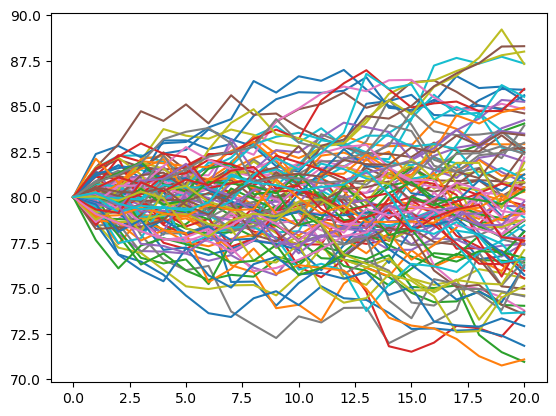

In [45]:
for i in range(len(call_price_heston_q5[1])):
    plt.plot(range(20+1), call_price_heston_q5[1][i])

In [5]:
np.random.seed(42)

put_option = OptionPricing(S_0, K, sigma, r, T, "put", "European")

put_price_heston_q5 = put_option.heston_pricing(v_0, kappa, theta, rho_q5, steps, iterations)

print(f"Price of European put option using Heston pricing model with -0.3 rho: {put_price_heston_q5}")

Price of European put option using Heston pricing model with -0.3 rho: 2.83


#### 6. Using the Heston Model and Monte-Carlo simulation, price an ATM European call and put, using a correlation value of -0.70.

In [6]:
rho_q6 = -0.70

In [7]:
np.random.seed(42)

call_price_heston_q6 = call_option.heston_pricing(v_0, kappa, theta, rho_q6, steps, iterations)

print(f"Price of European call option using Heston pricing model with -0.7 rho: {call_price_heston_q6}")

Price of European call option using Heston pricing model with -0.7 rho: 2.13


In [8]:
np.random.seed(42)

put_price_heston_q6 = put_option.heston_pricing(v_0, kappa, theta, rho_q6, steps, iterations)

print(f"Price of European put option using Heston pricing model with -0.7 rho: {put_price_heston_q6}")

Price of European put option using Heston pricing model with -0.7 rho: 3.44


#### 7. Calculate delta and gamma for each of the options in Questions 5 and 6. 

Delta is sensitivity of the price to a movement in the spot price, it’s related to the probability of the option finishing in-the-money.

With using Monte-Carlo Methods for computing the Greeks of options we numerically approximate by changing underlying stock price and implementing an estimate for the Delta. If there is a small move in the spot price S, then the price of the options will change by delta this small movement.

Gamma is the rate of change in Delta with respect to the change in option price.

In [9]:
np.random.seed(42)

def compute_delta_gamma(S_0, option_type, rho, op_price):

    S_0_range = [i for i in range(S_0 - 10, S_0 + 10) if i != S_0]
    price_list = []
    delta_list = []

    for s in S_0_range:
        if option_type == "call":
            price = OptionPricing(s, K, sigma, r, T, "call", "European").heston_pricing(v_0, kappa, theta, rho, steps, iterations)
        elif option_type == "put":
            price = OptionPricing(s, K, sigma, r, T, "put", "European").heston_pricing(v_0, kappa, theta, rho, steps, iterations)

        price_list.append(price)
        delta_list.append((price - op_price) / (s - S_0))

    delta = round(np.mean(delta_list), 2)
    gamma = round(np.mean(np.diff(delta_list) / np.diff(S_0_range)), 3)
    return delta, gamma


options = [(S_0, "call", rho_q5, call_price_heston_q5), 
           (S_0, "call", rho_q6, call_price_heston_q6), 
           (S_0, "put", rho_q5, put_price_heston_q5), 
           (S_0, "put", rho_q6, put_price_heston_q6)]


results = []
for spot, option_type, rho, op_price in options:
    delta, gamma = compute_delta_gamma(spot, option_type, rho, op_price)
    results.append((option_type, rho, delta, gamma))


print("{:<6} {:<6} {:<8} {:<8}".format("Type", "Rho", "Delta", "Gamma"))
print("-" * 28)
for row in results:
    print("{:<6} {:<6} {:<8} {:<8}".format(row[0], row[1], row[2], row[3]))

Type   Rho    Delta    Gamma   
----------------------------
call   -0.3   0.52     0.026   
call   -0.7   0.46     0.025   
put    -0.3   -0.48    0.024   
put    -0.7   -0.52    0.024   


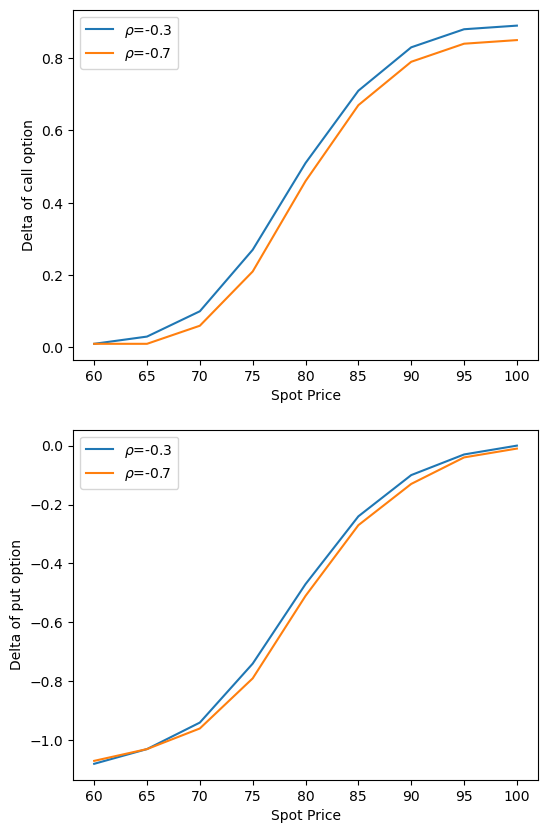

In [10]:
spots = range(60, 101, 5)
delta_call = {-0.3: [], -0.7: []}
delta_put = {-0.3: [], -0.7: []}

for spot in spots:
    call_op_price_3 = OptionPricing(spot, spot, sigma, r, T, "call", "European").heston_pricing(v_0, kappa, theta, -0.3, steps, iterations)
    delta_call[-0.3].append(compute_delta_gamma(spot, "call", -0.3, call_op_price_3)[0])
    call_op_price_7 = OptionPricing(spot, spot, sigma, r, T, "call", "European").heston_pricing(v_0, kappa, theta, -0.7, steps, iterations)
    delta_call[-0.7].append(compute_delta_gamma(spot, "call", -0.7, call_op_price_7)[0])
    put_op_price_3 = OptionPricing(spot, spot, sigma, r, T, "put", "European").heston_pricing(v_0, kappa, theta, -0.3, steps, iterations)
    delta_put[-0.3].append(compute_delta_gamma(spot, "put", -0.3, put_op_price_3)[0])
    put_op_price_7 = OptionPricing(spot, spot, sigma, r, T, "put", "European").heston_pricing(v_0, kappa, theta, -0.7, steps, iterations)
    delta_put[-0.7].append(compute_delta_gamma(spot, "put", -0.7, put_op_price_7)[0])
    
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

ax[0].plot(spots, delta_call[-0.3])
ax[0].plot(spots, delta_call[-0.7])
ax[0].legend(labels = [r"$\rho$=-0.3", r"$\rho$=-0.7"])
ax[0].set_xlabel("Spot Price")
ax[0].set_ylabel("Delta of call option")

ax[1].plot(spots, delta_put[-0.3])
ax[1].plot(spots, delta_put[-0.7])
ax[1].legend(labels = [r"$\rho$=-0.3", r"$\rho$=-0.7"])
ax[1].set_xlabel("Spot Price")
ax[1].set_ylabel("Delta of put option");

<div style="page-break-after: always;"></div>

## Jump Modeler

For the Merton model, you can use the following parameters:

$
\hspace{1em}\mu = - 0.5 \\
\hspace{1em}\delta = 0.22
$

$
\begin{align*}
S_t &= S_{t-1} \left(e^{\left(r - r_j - \frac{\sigma^2}{2}\right)dt + \sigma \sqrt{dt} z_t^1} + \left(e^{\mu_j + \delta z_t^2} - 1\right) y_t \right) \\
r_j &= \lambda \left(e^{\mu_j + \frac{\delta^2}{2}}\right) - 1
\end{align*}
$

$
\hspace{1em}\text{where,} \\
\hspace{2em}r_j = \text{Jump component of the interest rate, which is a Poisson distribution} \\
\hspace{2em}\mu = \text{Expected size of jump in underlying asset} \\
\hspace{2em}\delta = \text{Standard deviation of the jump in underlying asset} \\
\hspace{2em}z_t^1 = \text{Standard normally distributed random variable modelling the diffusion process} \\
\hspace{2em}z_t^2 = \text{Standard normally distributed random variable modelling the jump process}
$

The Merton process is a stochastic process used to model stock prices. It is an extension of the Black-Scholes model that includes the possibility of jumps in the stock price. The Merton process is a two-factor model, where the first factor is the geometric Brownian motion, and the second factor is a jump process. The jump process is characterized by two parameters, the jump intensity and the jump size.

In the Merton process, the stock price is modeled as the sum of two components: the first component is the continuous part of the process, which follows a geometric Brownian motion, and the second component is a jump process. The jump process is a Poisson process, which means that the jumps occur at random intervals with a certain probability. The jump size is also random, and follows a log-normal distribution.

To simulate the Merton process, a Monte Carlo simulation can be used. The simulation involves generating a large number of random paths for the stock price using the two-factor Merton model. The final stock value at time T is calculated for each path, and the option's payoff is then evaluated and discounted. The resulting values are averaged over all the paths to obtain an estimate of the option's price.

#### 8. Using the Merton Model, price an ATM European call and put with jump intensity parameter equal to 0.75.

In [11]:
lambda_q8 = 0.75
mu = -0.5
delt = 0.22

In [12]:
np.random.seed(42)

call_option = OptionPricing(S_0, K, sigma, r, T, "call", "European")

call_price_merton_q8 = call_option.merton_pricing(lambda_q8, mu, delt, steps, iterations)

print(f"Price of European call option using Merton pricing model with 0.75 lambda: {call_price_merton_q8}")

Price of European call option using Merton pricing model with 0.75 lambda: 8.18


In [13]:
np.random.seed(42)

put_option = OptionPricing(S_0, K, sigma, r, T, "put", "European")

put_price_merton_q8 = put_option.merton_pricing(lambda_q8, mu, delt, steps, iterations)

print(f"Price of European put option using Merton pricing model with 0.75 lambda: {put_price_merton_q8}")

Price of European put option using Merton pricing model with 0.75 lambda: 7.24


#### 9. Using the Merton Model, price an ATM European call and put with jump intensity parameter equal to 0.25.

In [14]:
lambda_q9 = 0.25

In [15]:
np.random.seed(42)

call_option = OptionPricing(S_0, K, sigma, r, T, "call", "European")

call_price_merton_q9 = call_option.merton_pricing(lambda_q9, mu, delt, steps, iterations)

print(f"Price of European call option using Merton pricing model with 0.25 lambda: {call_price_merton_q9}")

Price of European call option using Merton pricing model with 0.25 lambda: 6.72


In [16]:
np.random.seed(42)

put_option = OptionPricing(S_0, K, sigma, r, T, "put", "European")

put_price_merton_q9 = put_option.merton_pricing(lambda_q9, mu, delt, steps, iterations)

print(f"Price of European put option using Merton pricing model with 0.25 lambda: {put_price_merton_q9}")

Price of European put option using Merton pricing model with 0.25 lambda: 5.71


<div style="page-break-after: always;"></div>

#### 10. Calculate delta and gamma for each of the options in Questions 8 and 9.

In [17]:
np.random.seed(42)

def compute_delta_gamma(S_0, option_type, lamb, op_price):

    S_0_range = [i for i in range(S_0 - 10, S_0 + 10) if i != S_0]
    price_list = []
    delta_list = []

    for s in S_0_range:
        if option_type == "call":
            price = OptionPricing(s, K, sigma, r, T, "call", "European").merton_pricing(lamb, mu, delt, steps, iterations)
        elif option_type == "put":
            price = OptionPricing(s, K, sigma, r, T, "put", "European").merton_pricing(lamb, mu, delt, steps, iterations)

        price_list.append(price)
        delta_list.append((price - op_price) / (s - S_0))

    delta = round(np.mean(delta_list), 2)
    gamma = round(np.mean(np.diff(delta_list) / np.diff(S_0_range)), 3)
    return delta, gamma


options = [(S_0, "call", lambda_q8, call_price_heston_q5), 
           (S_0, "call", lambda_q9, call_price_heston_q6), 
           (S_0, "put", lambda_q8, put_price_heston_q5), 
           (S_0, "put", lambda_q9, put_price_heston_q6)]


results = []
for spot, option_type, lamb, op_price in options:
    delta, gamma = compute_delta_gamma(spot, option_type, lamb, op_price)
    results.append((option_type, lamb, delta, gamma))


print("{:<6} {:<6} {:<8} {:<8}".format("Type", "Lambda", "Delta", "Gamma"))
print("-" * 28)
for row in results:
    print("{:<6} {:<6} {:<8} {:<8}".format(row[0], row[1], row[2], row[3]))

Type   Lambda Delta    Gamma   
----------------------------
call   0.75   0.61     -0.223  
call   0.25   0.56     -0.189  
put    0.75   -0.38    -0.181  
put    0.25   -0.43    -0.087  


The results show that the delta and gamma values for the call and put options are higher for the jump intensity parameter of 0.75 compared to 0.25. This makes sense since a higher jump intensity parameter implies a higher probability of large jumps in the stock price, which increases the sensitivity of the option to changes in the stock price.

In the Merton jump-diffusion model, the jump intensity parameter determines the probability of observing large jumps in the stock price. When the jump intensity parameter is higher, there is a higher likelihood of observing large jumps in the stock price.

The delta and gamma values of an option measure its sensitivity to changes in the underlying asset price. Specifically, delta measures the change in option price in response to a small change in the underlying asset price, while gamma measures the rate of change of delta in response to changes in the underlying asset price.

When the jump intensity parameter is higher, there is a greater chance of observing larger price movements in the underlying asset due to the occurrence of jumps. This results in a higher sensitivity of the option price to changes in the underlying asset price, leading to higher delta and gamma values.

In contrast, when the jump intensity parameter is lower, there is a lower likelihood of observing large jumps in the stock price. Consequently, the option price will have a lower sensitivity to changes in the underlying asset price, resulting in lower delta and gamma values.

Therefore, it makes sense that the delta and gamma values are higher for the jump intensity parameter of 0.75 compared to 0.25, as the former corresponds to a higher probability of large jumps in the stock price.

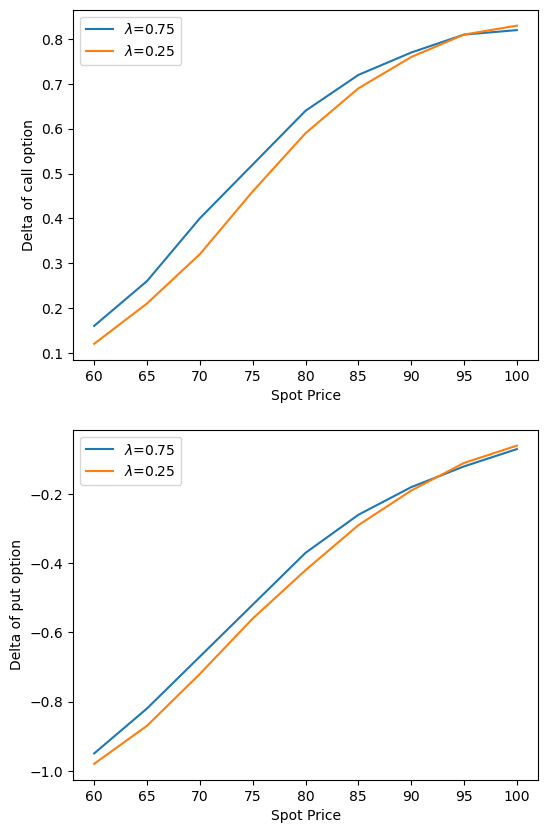

In [18]:
spots = range(60, 101, 5)
delta_call = {0.75: [], 0.25: []}
delta_put = {0.75: [], 0.25: []}

for spot in spots:
    call_op_price_75 = OptionPricing(spot, spot, sigma, r, T, "call", "European").merton_pricing(0.75, mu, delt, steps, iterations)
    delta_call[0.75].append(compute_delta_gamma(spot, "call", 0.75, call_op_price_75)[0])
    call_op_price_25 = OptionPricing(spot, spot, sigma, r, T, "call", "European").merton_pricing(0.25, mu, delt, steps, iterations)
    delta_call[0.25].append(compute_delta_gamma(spot, "call", 0.25, call_op_price_25)[0])
    put_op_price_75 = OptionPricing(spot, spot, sigma, r, T, "put", "European").merton_pricing(0.75, mu, delt, steps, iterations)
    delta_put[0.75].append(compute_delta_gamma(spot, "put", 0.75, put_op_price_75)[0])
    put_op_price_25 = OptionPricing(spot, spot, sigma, r, T, "put", "European").merton_pricing(0.25, mu, delt, steps, iterations)
    delta_put[0.25].append(compute_delta_gamma(spot, "put", 0.25, put_op_price_25)[0])
    
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

ax[0].plot(spots, delta_call[0.75])
ax[0].plot(spots, delta_call[0.25])
ax[0].legend(labels = [r"$\lambda$=0.75", r"$\lambda$=0.25"])
ax[0].set_xlabel("Spot Price")
ax[0].set_ylabel("Delta of call option")

ax[1].plot(spots, delta_put[0.75])
ax[1].plot(spots, delta_put[0.25])
ax[1].legend(labels = [r"$\lambda$=0.75", r"$\lambda$=0.25"])
ax[1].set_xlabel("Spot Price")
ax[1].set_ylabel("Delta of put option");

#### 11. For Questions 5, 6, 8, and 9, use put-call Parity to determine if the prices of the put and call from the Heston Model and Merton Model satisfy put-call parity.

In [19]:
def put_call_parity(call_price, put_price):
    lhs = np.round(call_price + K * np.exp(-r * T), 2)
    rhs = np.round(put_price + S_0, 2)
    print(f"LHS: {lhs} \nRHS: {rhs}")

##### Question 5

In [20]:
put_call_parity(call_price_heston_q5, put_price_heston_q5)

LHS: 81.78 
RHS: 82.83


##### Question 6

In [21]:
put_call_parity(call_price_heston_q6, put_price_heston_q6)

LHS: 81.04 
RHS: 83.44


##### Question 7

In [22]:
put_call_parity(call_price_merton_q8, put_price_merton_q8)

LHS: 87.09 
RHS: 87.24


##### Question 8

In [23]:
put_call_parity(call_price_merton_q9, put_price_merton_q9)

LHS: 85.63 
RHS: 85.71


With the Merton pricing, the put-call parity is satisfied, but with Heston, the put-call parity is not satisfied. This is because of the randomness involved in the stochastic volatility process $\left(\nu\right)$. This suggests an arbitrage oppurtunity, where an investor may exploit to gain risk-free profits.

<div style="page-break-after: always;"></div>

#### 12. Run the Heston Model and Merton Model for 7 different strikes: 3 OTM calls; 1ATM call; and 3 ITM calls. The strikes should be equally spaced. Try to use the following approximate moneyness values: 0.85, 0.90, 0.95, 1, 1.05, 1.10, and 1.15

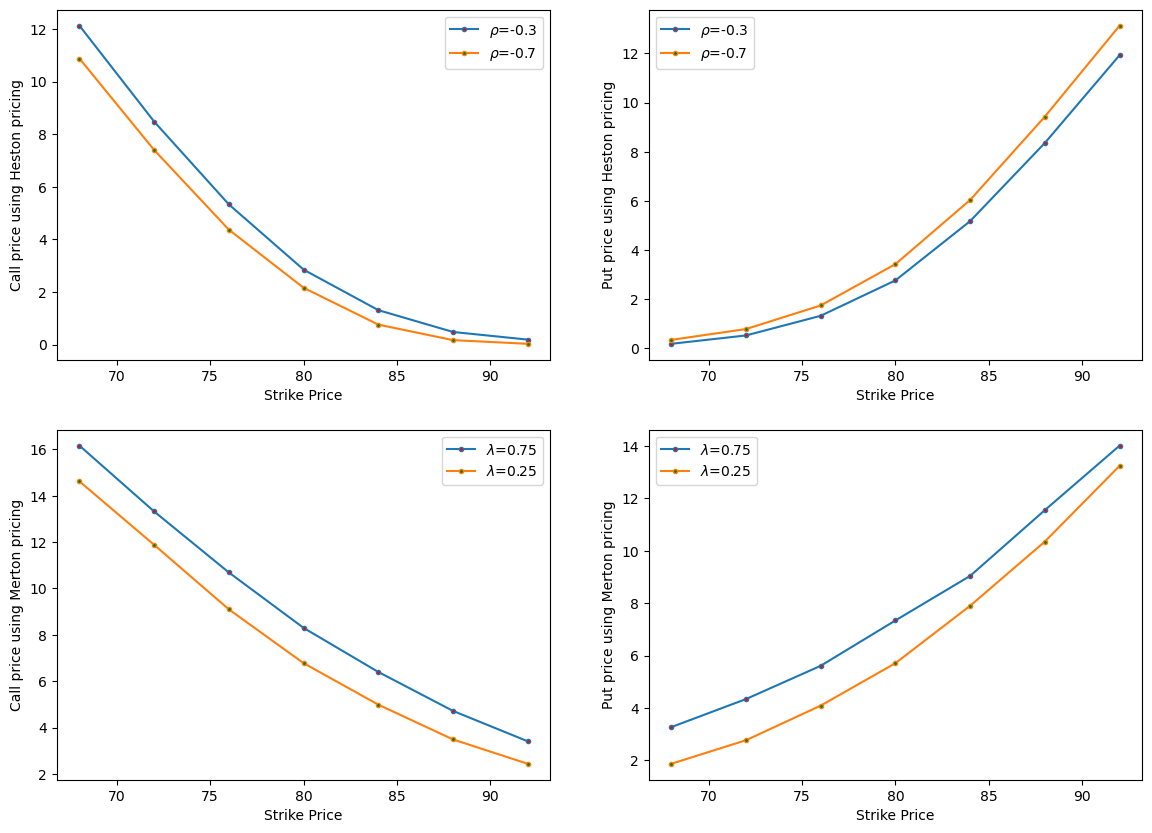

In [24]:
strikes = (np.array([0.85, 0.90, 0.95, 1, 1.05, 1.10, 1.15]) * S_0).astype(int)

call_prices_heston_q5 = []
call_prices_heston_q6 = []
put_prices_heston_q5 = []
put_prices_heston_q6 = []

call_prices_merton_q8 = []
call_prices_merton_q9 = []
put_prices_merton_q8 = []
put_prices_merton_q9 = []

for strike in strikes:
    call_option = OptionPricing(S_0, strike, sigma, r, T, "call", "European")
    put_option = OptionPricing(S_0, strike, sigma, r, T, "put", "European")
    
    call_prices_heston_q5.append(call_option.heston_pricing(v_0, kappa, theta, rho_q5, steps, iterations))
    call_prices_heston_q6.append(call_option.heston_pricing(v_0, kappa, theta, rho_q6, steps, iterations))
    put_prices_heston_q5.append(put_option.heston_pricing(v_0, kappa, theta, rho_q5, steps, iterations))
    put_prices_heston_q6.append(put_option.heston_pricing(v_0, kappa, theta, rho_q6, steps, iterations))
    
    call_prices_merton_q8.append(call_option.merton_pricing(lambda_q8, mu, delt, steps, iterations))
    call_prices_merton_q9.append(call_option.merton_pricing(lambda_q9, mu, delt, steps, iterations))
    put_prices_merton_q8.append(put_option.merton_pricing(lambda_q8, mu, delt, steps, iterations))
    put_prices_merton_q9.append(put_option.merton_pricing(lambda_q9, mu, delt, steps, iterations))
    
    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

ax[0,0].plot(strikes, call_prices_heston_q5, marker=".", markerfacecolor="r")
ax[0,0].plot(strikes, call_prices_heston_q6, marker=".", markerfacecolor="g")
ax[0,0].legend(labels = [r"$\rho$=-0.3", r"$\rho$=-0.7"])
ax[0,0].set_xlabel("Strike Price")
ax[0,0].set_ylabel("Call price using Heston pricing")

ax[0,1].plot(strikes, put_prices_heston_q5, marker=".", markerfacecolor="r")
ax[0,1].plot(strikes, put_prices_heston_q6, marker=".", markerfacecolor="g")
ax[0,1].legend(labels = [r"$\rho$=-0.3", r"$\rho$=-0.7"])
ax[0,1].set_xlabel("Strike Price")
ax[0,1].set_ylabel("Put price using Heston pricing")

ax[1,0].plot(strikes, call_prices_merton_q8, marker=".", markerfacecolor="r")
ax[1,0].plot(strikes, call_prices_merton_q9, marker=".", markerfacecolor="g")
ax[1,0].legend(labels = [r"$\lambda$=0.75", r"$\lambda$=0.25"])
ax[1,0].set_xlabel("Strike Price")
ax[1,0].set_ylabel("Call price using Merton pricing")

ax[1,1].plot(strikes, put_prices_merton_q8, marker=".", markerfacecolor="r")
ax[1,1].plot(strikes, put_prices_merton_q9, marker=".", markerfacecolor="g")
ax[1,1].legend(labels = [r"$\lambda$=0.75", r"$\lambda$=0.25"])
ax[1,1].set_xlabel("Strike Price")
ax[1,1].set_ylabel("Put price using Merton pricing");

In case of Heston pricing model, stochastic correlation between the log price process $S_t$ and the stochastic variance $\nu_t$, we note that when the negative correlation between the Brownian movement of the price and the variance increases (from -0.3 to -0.7), the price of the call option decreases at different strike prices and vice versa with the put option.
It is distinctly observed that the correlation indeed affects the shape of the implied price  curve. In particular, a negative correlation induces a declining sloping curve. when $\rho$ < 0, the distribution of $ln(S_T)$ is negatively skewed This implies that deep ITM calls from the Heston model should be more expensive than the Black-Scholes model.

In the case of Merton pricing model, with the increase in the jump parameter, the price of both call and put option increases, which is due to the increase in fluctuation of the simulated prices.

#### 13. Repeat Questions 5 and 8 for the case of an American option. Comment on the differences you observe from original Questions 5 and 8.

For pricing an American option, following modification is done to the European option pricing strategy.

* Each iteration is traversed from time 0 to end of the timesteps and check if the option should be exercised at that time step.

* If the option can be exercised early, the discounted price at that point is used to replace the discounted price at maturity.

* Finally, the mean of the discounted price over all iterations is computed as the price of American option.

In [25]:
rho_q13 = -0.30

In [26]:
np.random.seed(42)

call_option = OptionPricing(S_0, K, sigma, r, T, "call", "American")

call_price_heston_q13 = call_option.heston_pricing(v_0, kappa, theta, rho_q13, steps, iterations)

print(f"Price of American call option using Heston pricing model with -0.3 rho: {call_price_heston_q13}")

Price of American call option using Heston pricing model with -0.3 rho: 2.87


In [27]:
np.random.seed(42)

put_option = OptionPricing(S_0, K, sigma, r, T, "put", "American")

put_price_heston_q13 = put_option.heston_pricing(v_0, kappa, theta, rho_q13, steps, iterations)

print(f"Price of American put option using Heston pricing model with -0.3 rho: {put_price_heston_q13}")

Price of American put option using Heston pricing model with -0.3 rho: 2.83


<br></br>
<br></br>
<br></br>

In [28]:
lambda_q13 = 0.75

In [29]:
np.random.seed(42)

call_option = OptionPricing(S_0, K, sigma, r, T, "call", "American")

call_price_merton_q13 = call_option.merton_pricing(lambda_q13, mu, delta, steps, iterations)

print(f"Price of American call option using Merton pricing model with 0.75 lambda: {call_price_merton_q13}")

Price of American call option using Merton pricing model with 0.75 lambda: 8.35


In [30]:
np.random.seed(42)

put_option = OptionPricing(S_0, K, sigma, r, T, "put", "American")

put_price_merton_q13 = put_option.merton_pricing(lambda_q13, mu, delta, steps, iterations)

print(f"Price of American put option using Merton pricing model with 0.75 lambda: {put_price_merton_q13}")

Price of American put option using Merton pricing model with 0.75 lambda: 7.72


<div style="page-break-after: always;"></div>

#### 14. Using Heston model data from Question 6, price a European up-and-in call option (UAI) with a barrier level of 95 and a strike price of 95 as well. Compare the price obtained to the one from the simple European call.

In [31]:
rho_q14 = -0.3

In [32]:
S_0 = 80
K = 95
uai = 95

call_option = OptionPricing(S_0, K, sigma, r, T, "call", "European")

np.random.seed(42)
simple_european_call = call_option.heston_pricing(v_0, kappa, theta, rho_q14, steps, iterations)

np.random.seed(42)
uai_european_call = call_option.heston_pricing(v_0, kappa, theta, rho_q14, steps, iterations, uai)

print(f"Price of simple European call: {simple_european_call}")
print(f"Price of UAI European call: {uai_european_call}")

Price of simple European call: 0.08
Price of UAI European call: 0.08


This is because, the barrier would only be valid when UAI is greater than the strike price. When UAI is less than strike price, the price of an Up and In option is equal to a Vanilla option

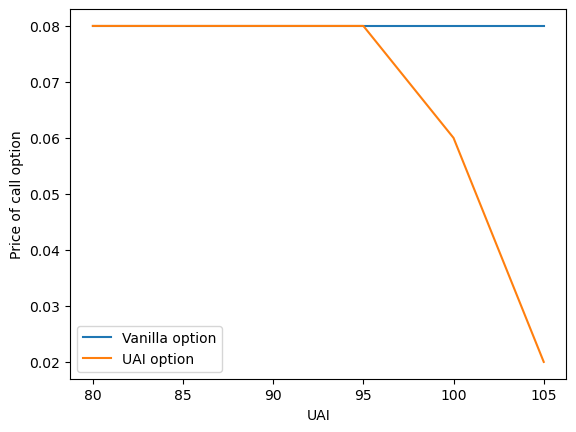

In [33]:
prices_without_uai = {}
prices_with_uai = {}

for uai in range(80, 110, 5):
    np.random.seed(42)
    prices_without_uai[uai] = call_option.heston_pricing(v_0, kappa, theta, rho_q14, steps, iterations)
                                                         
    np.random.seed(42)                                                   
    prices_with_uai[uai] = call_option.heston_pricing(v_0, kappa, theta, rho_q14, steps, iterations, uai)
    
plt.plot(prices_without_uai.keys(), prices_without_uai.values())
plt.plot(prices_with_uai.keys(), prices_with_uai.values())
plt.xlabel("UAI")
plt.ylabel("Price of call option")
plt.legend(labels = ["Vanilla option", "UAI option"]);

<div style="page-break-after: always;"></div>

#### 15. Using Merton model data from Question 8, price a European down-and-in put option (DAI) with a barrier level of 65 and a strike price of 65 as well. Compare the price obtained to the one from the simple European put.

In [34]:
lambda_q15 = 0.25

In [35]:
S_0 = 80
K = 65
dai = 65


put_option = OptionPricing(S_0, K, sigma, r, T, "put", "European")

np.random.seed(42)
simple_european_put = put_option.merton_pricing(lambda_q15, mu, delt, steps, iterations)

np.random.seed(42)
dai_european_put = put_option.merton_pricing(lambda_q15, mu, delt, steps, iterations, dai)

print(f"Price of simple European put: {simple_european_put}")
print(f"Price of DAI European put: {dai_european_put}")

Price of simple European put: 1.39
Price of DAI European put: 1.39


Similar to question 14, the DAI option becomes valid only when the barrier is less than the strike price.

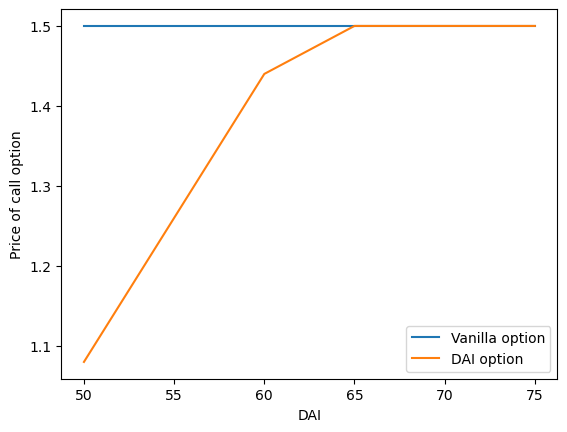

In [36]:
prices_without_dai = {}
prices_with_dai = {}

for dai in range(50, 80, 5):
    np.random.seed(42)
    prices_without_dai[dai] = put_option.merton_pricing(lambda_q15, mu, delta, steps, iterations)
                                                         
    np.random.seed(42)                                                   
    prices_with_dai[dai] = put_option.merton_pricing(lambda_q15, mu, delta, steps, iterations, dai)
    
plt.plot(prices_without_dai.keys(), prices_without_dai.values())
plt.plot(prices_with_dai.keys(), prices_with_dai.values())
plt.xlabel("DAI")
plt.ylabel("Price of call option")
plt.legend(labels = ["Vanilla option", "DAI option"]);